In [124]:
#Import the required libraries

import numpy as np
import pandas as pd 
import pickle
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, confusion_matrix, accuracy_score

In [5]:
df = pd.read_csv('spam.csv', encoding='latin1')
#encoding is required when there are non ASCII characters in the file

In [7]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [9]:
df.shape

(5572, 5)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


## Data Cleaning

In [14]:
#Removing non relavent columns
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [18]:
# Renaming columns to a more appropriate name
df.rename(columns={'v1': 'target', 'v2': 'text'}, inplace=True)
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [20]:
#Encode the column named "target"
encoder = LabelEncoder()

In [22]:
df['target'] = encoder.fit_transform(df['target'])

In [24]:
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [26]:
#Check for missing values
df.isnull().sum()   #No missing values

target    0
text      0
dtype: int64

In [28]:
#Check for duplicate values
df.duplicated().sum()

403

In [30]:
#Remove duplicates
df = df.drop_duplicates(keep='first') #Except first occurence drop all duplicates

In [32]:
df.duplicated().sum()

0

In [34]:
df.shape

(5169, 2)

## Data Analysis & Preprocessing

In [37]:
#Number of spam & not spam texts
df['target'].value_counts()

target
0    4516
1     653
Name: count, dtype: int64

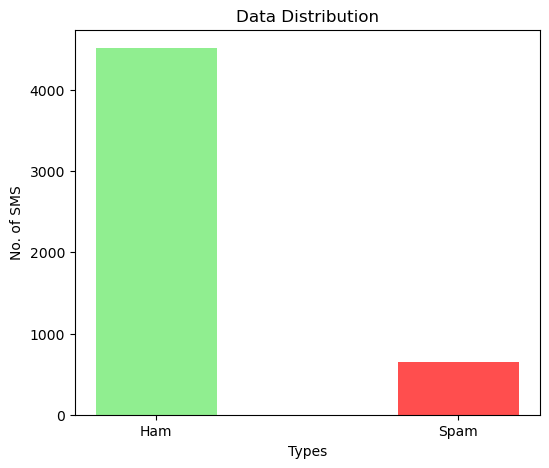

In [39]:
import matplotlib.pyplot as plt
counts = df['target'].value_counts()

# Plotting the bar chart
fig = plt.figure(figsize=(6, 5))
plt.bar(['Ham', 'Spam'], counts.values, color=['#90ee90','#ff4e4e'], width=0.4)
plt.xlabel("Types")
plt.ylabel("No. of SMS")
plt.title("Data Distribution")
plt.show()

In [41]:
def transform_text(text):
    text = text.lower()   #Convert to lowercase
    text = text.split()   #Split text 

    ps = PorterStemmer()  #To find the root form of the words
    
    final_text = []
    for i in text:
        if (i.isalnum()) and (i not in stopwords.words('english')) and (i not in string.punctuation):
            final_text.append(ps.stem(i))   #Remove special characters, puntuations and stopwords 
    
    return " ".join(final_text)     #Returning in string format

In [43]:
df['transformed_text'] = df['text'].apply(transform_text) #New column containing the transformed text
df.head()

,target,text,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",go jurong avail bugi n great world la e cine g...
1,0,Ok lar... Joking wif u oni...,ok joke wif u
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,u dun say earli u c alreadi
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think goe live around though


In [100]:
wc = WordCloud(width = 500, height = 500, min_font_size = 10, background_color = 'white')

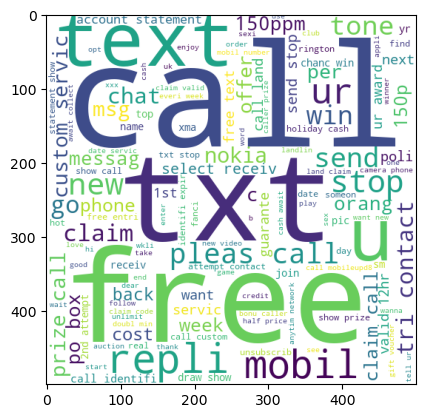

In [119]:
spam_wc = wc.generate(df[df['target']== 1]['transformed_text'].str.cat(sep=" "))
plt.imshow(spam_wc)

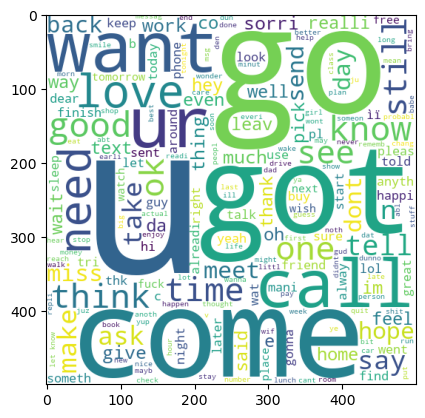

In [112]:
ham_wc = wc.generate(df[df['target']== 0]['transformed_text'].str.cat(sep=" "))
plt.imshow(ham_wc)

In [63]:
tfidf = TfidfVectorizer(max_features = 2500)

X = tfidf.fit_transform(df['transformed_text']).toarray()
Y = df["target"].values

In [65]:
# Splitting the testing and training sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Model Training and testing

In [68]:
classifier1 = MultinomialNB()
classifier1.fit(X_train, Y_train)

y_pred1 = classifier1.predict(X_test)

print("Naive Bayes:")
print()
cv_score = cross_val_score(classifier1, X_train,Y_train,scoring="accuracy", cv=10)
print("%s: %f " % ("Cross Validation Score", cv_score.mean()))

print("Accuracy: ",accuracy_score(Y_test, y_pred1))
print("Confusion Matrix: ")
print(confusion_matrix(Y_test, y_pred1))
print("Precision: ",precision_score(Y_test, y_pred1))

Naive Bayes:

Cross Validation Score: 0.963000 
Accuracy:  0.9661508704061895
Confusion Matrix: 
[[889   0]
 [ 35 110]]
Precision:  1.0


In [70]:
classifier2 = RandomForestClassifier()
classifier2.fit(X_train, Y_train)

y_pred2 = classifier2.predict(X_test)

print("Random Forest:")
print()

cv_score = cross_val_score(classifier2, X_train,Y_train,scoring="accuracy", cv=10)
print("%s: %f " % ("Cross Validation Score", cv_score.mean()))

print("Accuracy: ",accuracy_score(Y_test, y_pred2))
print("Confusion Matrix: ")
print(confusion_matrix(Y_test, y_pred2))
print("Precision: ",precision_score(Y_test, y_pred2))

Random Forest:

Cross Validation Score: 0.970013 
Accuracy:  0.9671179883945842
Confusion Matrix: 
[[886   3]
 [ 31 114]]
Precision:  0.9743589743589743


In [126]:
classifier3 = KNeighborsClassifier()
classifier3.fit(X_train, Y_train)

y_pred3 = classifier3.predict(X_test)

print("K Neighbours:")
print()

cv_score = cross_val_score(classifier3, X_train,Y_train,scoring="accuracy", cv=10)
print("%s: %f " % ("Cross Validation Score", cv_score.mean()))

print("Accuracy: ",accuracy_score(Y_test, y_pred3))
print("Confusion Matrix: ")
print(confusion_matrix(Y_test, y_pred3))
print("Precision: ",precision_score(Y_test, y_pred3))

K Neighbours:

Cross Validation Score: 0.905437 
Accuracy:  0.9052224371373307
Confusion Matrix: 
[[889   0]
 [ 98  47]]
Precision:  1.0


In [128]:
pickle.dump(tfidf, open('vectorizer.pkl','wb'))
pickle.dump(classifier1, open('NBmodel.pkl','wb'))
pickle.dump(classifier2, open('RFmodel.pkl','wb'))
pickle.dump(classifier3, open('KNmodel.pkl','wb'))